# Tutorial

This Python notebook demonstrates how OASIS can be used to efficiently evaluate a classifier, based on an example dataset from the entity resolution domain.

We begin by loading the required packages (including OASIS) and setting the random seeds for reproducability.

In [1]:
import numpy as np
import random
import oasis
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(319158)
random.seed(319158)

## Example dataset

The dataset we shall use for this tutorial is derived from the `Amazon-GoogleProducts` dataset available from [here](http://dbs.uni-leipzig.de/en/research/projects/object_matching/fever/benchmark_datasets_for_entity_resolution). It is described in the following publication:

> H. Köpcke, A. Thor, and E. Rahm. "Evaluation of entity resolution approaches on real-world match problems." *Proceedings of the VLDB Endowment* 3.1-2 (2010): 484-493.

The dataset consists of product listings from two e-commerce websites: *Amazon* and *Google Products* (which no longer exists as of 2017). Our goal is to train a classifier to identify pairs of records across the two data sources which refer to the same products. This involves forming the cross join of the two data sources and classifying each pair of records as a "match" or "non-match". Since the focus of this notebook is evaluation, we shall not demonstrate how to build the classifier here. Instead, we shall load the data from a classifier we prepared earlier.

### Loading the data

Using our pre-trained classifier, we calculated predictions and scores on a test set containing 676,267 record pairs. The data is stored in HDF5 format and is available in the GitHub repository.

Below, we make use of the ``Data`` class in the OASIS package to read the HDF file into memory.

In [2]:
data = oasis.Data()
data.read_h5('Amazon-GoogleProducts-test.h5')
data.calc_true_performance() #: calculate true precision, recall, F1-score

## Evaluating the classifier

Our goal is to estimate the F1-score of the classifier by sequentially labelling items in the test set. This example is somewhat contrived since we already know the ground truth labels (they are included with the test set). However, we can simulate the labelling by defining an oracle which looks up the labels as follows:

In [3]:
def oracle(idx):
    return data.labels[idx]

In the following experiments, we shall adopt the parameter settings below:

In [4]:
alpha = 0.5      #: corresponds to F1-score
n_labels = 5000  #: stop sampling after querying this number of labels
max_iter = 1e6   #: maximum no. of iterations that can be stored

### OASIS

Here we use the OASIS method to estimate the F1-score. The first step is to initialise the sampler.

In [5]:
smplr = oasis.OASISSampler(alpha, data.preds, data.scores, oracle, max_iter=max_iter)

Automatically setting n_bins = 2398.
Automatically setting goal_n_strata = 63.


Next we query ``n_labels`` sequentially.

In [6]:
smplr.sample_distinct(n_labels)

Finally, we plot the history of estimates to check for convergence. Since we already know the true value of the F1-score for this example (because we were given all of the labels in advance), we have indicated it on the plot using a red line. 

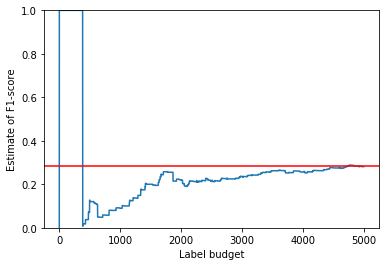

In [7]:
def plt_estimates(smplr, true_value):
    plt.plot(smplr.estimate_[smplr.queried_oracle_])
    plt.axhline(y=true_value, color='r')
    plt.xlabel("Label budget")
    plt.ylabel("Estimate of F1-score")
    plt.ylim(0,1)
    plt.show()

plt_estimates(smplr, data.F1_measure)

### Other samplers

For comparison, we repeat the evaluation using two alternative sampling methods available in the OASIS package.

First, we test the basic passive sampling method. It performs poorly due to the extreme class imbalance. Of the 5000 labels queried, none of them correspond to a true positive, yielding an incorrect estimate for the F1-score of 0.0.

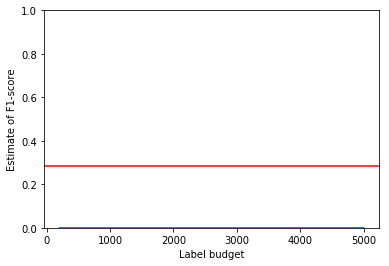

In [8]:
pass_smplr = oasis.PassiveSampler(alpha, data.preds, oracle, max_iter=max_iter)
pass_smplr.sample_distinct(n_labels)
plt_estimates(pass_smplr, data.F1_measure)

The non-adaptive importance sampling method fares better, yielding a decent estimate after consuming 5000 labels. However, it takes longer to converge than OASIS.

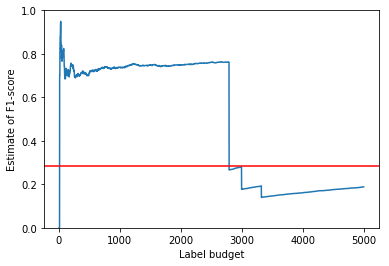

In [9]:
is_smplr = oasis.ImportanceSampler(alpha, data.preds, data.scores, oracle, max_iter=max_iter)
is_smplr.sample_distinct(n_labels)
plt_estimates(is_smplr, data.F1_measure)